In [1]:
cd ..

/Users/minghuang/Documents/git/SEA_traffic_accident_prediction


In [2]:
from data_processing_scripts import socrata_api_wrapper as saw
from data_processing_scripts import psql_helper as ph 
from data_processing_scripts import footballdb_scraper as fs
from data_processing_scripts import baseball_almanac_scraper as bas
from data_processing_scripts import wunderground_scraper as ws
from data_processing_scripts import mariner_games_downloader as mgd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
import psycopg2
import seaborn as sns
%matplotlib inline

###Get Wunderground historical weather data

In [3]:
wunder = ws.WundergroundScraper()
wunder.download_date_range('2009-06-17', '2015-09-29')

/Users/minghuang/Documents/git/SEA_traffic_accident_prediction/data_processing_scripts/../data/weather.csv downloaded.


### Get 911 response data (original data source intended, traffic accident data seemed insufficient)

In [4]:
token = 'Opp5gz1KaGplrPjbqnSsWkqHB'

In [5]:
api = saw.SocrataAPI(token)
r = api.request('https://data.seattle.gov/resource/pu5n-trf4.json')
headers = r.get_headers()
r.set_primary_id('cad_cdw_id')

In [6]:
r.download_csv(file_name='data/raw_911_response.csv')

Download Complete


###Get Mariner and Seahawks schedule

In [9]:
# Only contains historical games
mariner = bas.BaseballAlmanacScraper()
mariner.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [3]:
# Upcoming games
mgd.download_upcoming_mariner_games()

File downloaded.


In [10]:
seahawks = fs.FootballdbScraper()
seahawks.download_years([2009, 2010, 2011, 2012, 2013, 2014, 2015])

###Load all data into csv

In [4]:
psql = ph.PsqlConnection(db='traffic_accident', user='minghuang')

Connection Open


In [5]:
psql.load_csvs_in_directory('/Users/minghuang/Documents/git/SEA_traffic_accident_prediction/data')

Table raw_911_response dropped.
Table raw_911_response created in traffic_accident
CSV inserted into raw_911_response.
Table SEA_2009 dropped.
Table SEA_2009 created in traffic_accident
CSV inserted into SEA_2009.
Table SEA_2010 dropped.
Table SEA_2010 created in traffic_accident
CSV inserted into SEA_2010.
Table SEA_2011 dropped.
Table SEA_2011 created in traffic_accident
CSV inserted into SEA_2011.
Table SEA_2012 dropped.
Table SEA_2012 created in traffic_accident
CSV inserted into SEA_2012.
Table SEA_2013 dropped.
Table SEA_2013 created in traffic_accident
CSV inserted into SEA_2013.
Table SEA_2014 dropped.
Table SEA_2014 created in traffic_accident
CSV inserted into SEA_2014.
Table SEA_2015 dropped.
Table SEA_2015 created in traffic_accident
CSV inserted into SEA_2015.
Table seattle_seahawks_2009 dropped.
Table seattle_seahawks_2009 created in traffic_accident
CSV inserted into seattle_seahawks_2009.
Table seattle_seahawks_2010 dropped.
Table seattle_seahawks_2010 created in traffi

In [6]:
psql.end_connection()

Connection Closed


In [10]:
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_views.sql

psql:data_processing_scripts/psql_queries/create_views.sql:3: NOTICE:  view "mariner_schedule" does not exist, skipping
DROP VIEW
CREATE VIEW
psql:data_processing_scripts/psql_queries/create_views.sql:59: NOTICE:  drop cascades to view seahawk_plays
DROP VIEW
CREATE VIEW
psql:data_processing_scripts/psql_queries/create_views.sql:84: NOTICE:  view "mariner_plays" does not exist, skipping
DROP VIEW
CREATE VIEW
psql:data_processing_scripts/psql_queries/create_views.sql:96: NOTICE:  view "seahawk_plays" does not exist, skipping
DROP VIEW
CREATE VIEW


In [86]:
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_categorical_mappings.sql

DROP TABLE
SELECT 52
DROP TABLE
SELECT 28
DROP TABLE
SELECT 18


In [87]:
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_zone_latlong_view.sql

DROP VIEW
CREATE VIEW


In [88]:
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_model_data_view.sql
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_train_data_view.sql
!psql -d traffic_accident -f data_processing_scripts/psql_queries/create_test_data_view.sql

psql:data_processing_scripts/psql_queries/create_model_data_view.sql:1: NOTICE:  view "model_data" does not exist, skipping
DROP VIEW
CREATE VIEW
psql:data_processing_scripts/psql_queries/create_train_data_view.sql:1: NOTICE:  view "train_data" does not exist, skipping
DROP VIEW
CREATE VIEW
psql:data_processing_scripts/psql_queries/create_test_data_view.sql:1: NOTICE:  view "test_data" does not exist, skipping
DROP VIEW
CREATE VIEW


#EDA

In [181]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
query = "select * from raw_911_response where event_clearance_code like '4%';"
df = pd.read_sql_query(query, con=conn)
conn.close()

In [182]:
df.head()

,cad_cdw_id,at_scene_time,cad_event_number,census_tract,district_sector,event_clearance_code,event_clearance_date,event_clearance_description,event_clearance_group,event_clearance_subgroup,general_offense_number,hundred_block_location,incident_location,initial_type_description,initial_type_group,initial_type_subgroup,latitude,longitude,zone_beat
0,58014,,10000307639,9300.3087,O,460,2010-09-02T21:14:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2010307639,45XX BLOCK OF DIAGONAL AVE S,"{u'type': u'Point', u'coordinates': [-122.3387...",,,,47.562643686,-122.338763147,O2
1,580138,2012-07-13T02:25:00.000,12000224040,8100.2028,K,460,2012-07-13T02:29:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224040,5XX BLOCK OF 4TH AVE,"{u'type': u'Point', u'coordinates': [-122.3299...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.602876296,-122.329971419,K1
2,580128,,15000034202,8002.2006,M,440,2015-01-30T14:52:00.000,MOTORIST ASSIST,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,201534202,1 AV / LENORA ST,"{u'type': u'Point', u'coordinates': [-122.3439...",TRAFFIC - BLOCKING ROADWAY,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.611836283,-122.34391552,M1
3,580126,2012-07-13T13:01:00.000,12000224547,8100.1000,M,460,2012-07-13T13:08:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224547,13XX BLOCK OF 1ST AVE,"{u'type': u'Point', u'coordinates': [-122.3386...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.607331584,-122.33865117,M1
4,580123,2012-07-13T15:44:00.000,12000224768,9300.3018,O,460,2012-07-13T15:59:00.000,TRAFFIC (MOVING) VIOLATION,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,2012224768,19XX BLOCK OF 1ST AVE S,"{u'type': u'Point', u'coordinates': [-122.3341...",TRAFFIC STOP - OFFICER INITIATED ONVIEW,TRAFFIC RELATED CALLS,TRAFFIC RELATED CALLS,47.585041313,-122.334198304,O1


In [185]:
lgt = df.longitude.astype(float).values
lat = df.latitude.astype(float).values

In [186]:
print min(lgt), max(lgt)
print min(lat), max(lat)

-122.432252473 -122.217417743
47.448669479 47.777823617


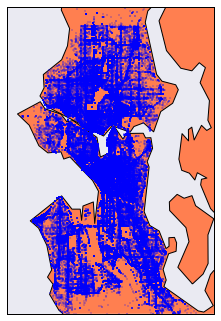

In [187]:
m = Basemap(projection='merc',# lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.45, llcrnrlat=47.5,
    urcrnrlon=-122.2, urcrnrlat=47.75)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'coral')
m.drawmapboundary()

x, y = m(lgt, lat)
m.plot(x, y, 'bo', markersize=1)
 
plt.show()

#### Lets look at my sql transformed data (additional EDA were done in SQL, but not recorded)

In [49]:
query1 = 'select * from train_data;'
query2 = 'select * from test_data;'

In [39]:
conn = psycopg2.connect(dbname='traffic_accident', user='minghuang', host='localhost')
train_df = pd.read_sql_query(query1, con=conn)
test_df = pd.read_sql_query(query2, con=conn)
conn.close()

In [50]:
train_df.head().T

,0,1,2,3,4
zone_beat_id,24.00,45.00,9.00,52.00,33.00
condition_id,1.00,3.00,4.00,4.00,1.00
winddir_id,1.00,15.00,10.00,11.00,3.00
intersections,302.00,344.00,264.00,243.00,297.00
hour,1.00,6.00,19.00,1.00,14.00
dow,2.00,4.00,4.00,5.00,5.00
month,1.00,1.00,1.00,1.00,1.00
mariner_plays,0.00,0.00,0.00,0.00,0.00
seahawk_plays,0.00,0.00,0.00,0.00,0.00
dewpoint,28.90,19.90,30.00,35.10,42.10


In [53]:
df2 = train_df[['dewpoint', 'have_gustspeed', 'have_heatindex', 'humidity', 'have_precip', 'pressure', 'temp', 'visibility', 'windspeed', 'label']]

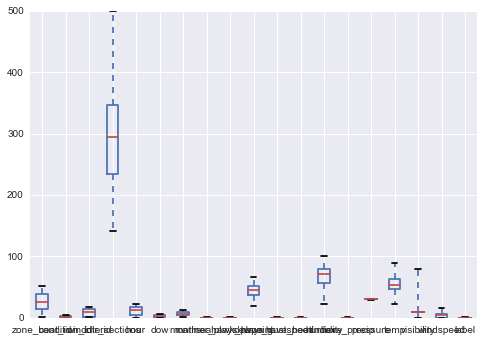

In [52]:
plot = train_df.boxplot()

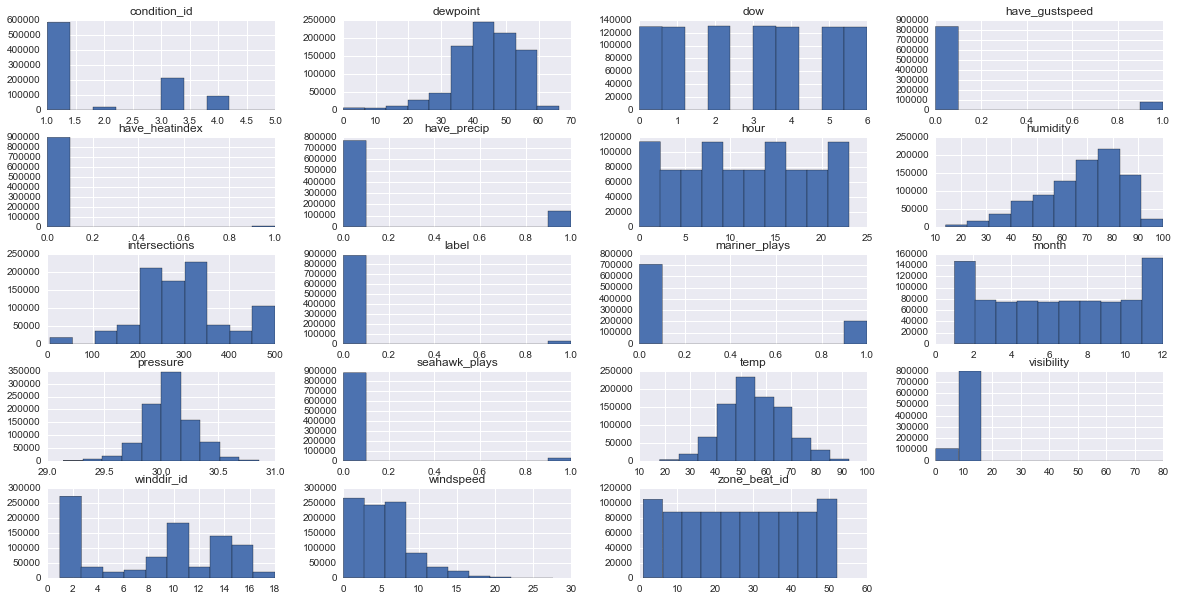

In [54]:
plot = train_df.hist(figsize=(20, 10))

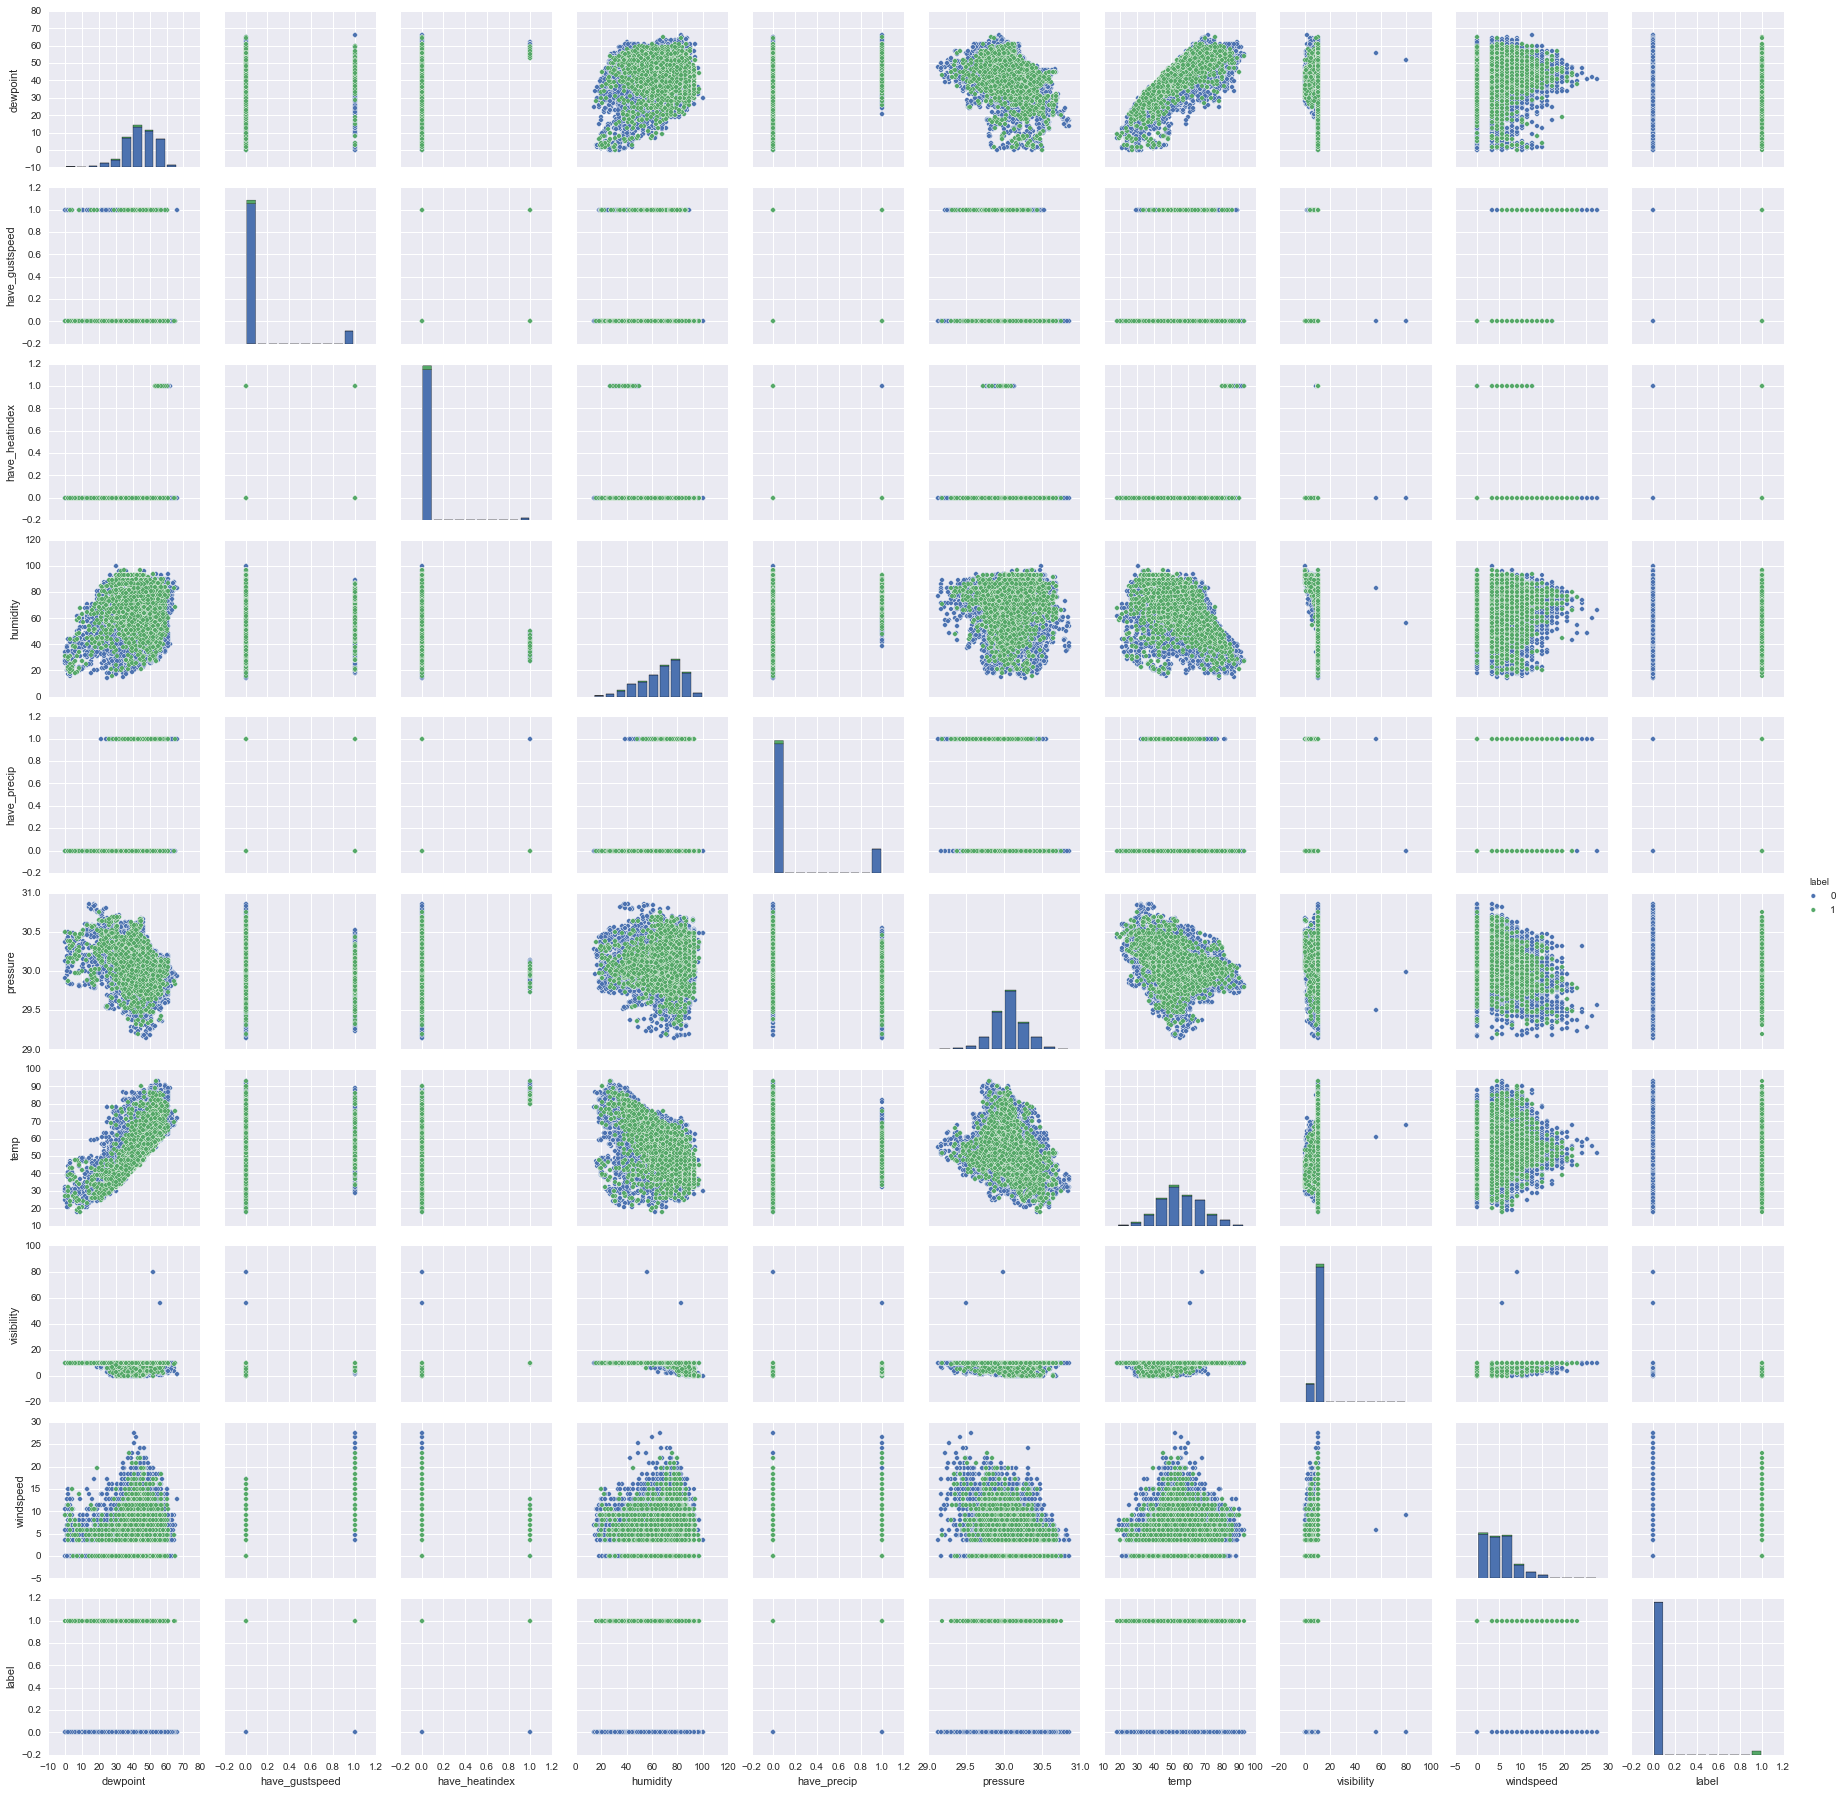

In [56]:
df2_sample = df2.sample(100000)
sns.set()
sns.pairplot(df2_sample, hue='label')

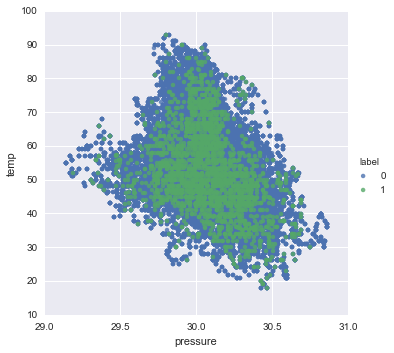

In [57]:
sns.set()
sns.lmplot('pressure', 'temp', hue='label', data=df2_sample, fit_reg=False)

In [59]:
train_sample = train_df.sample(100000)
train_sample_pos = train_sample[train_sample.label == 1]
train_sample_neg = train_sample[train_sample.label == 0]

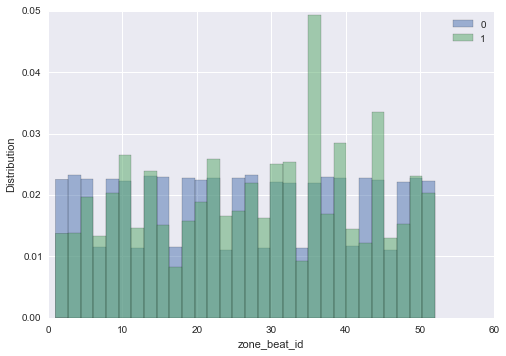

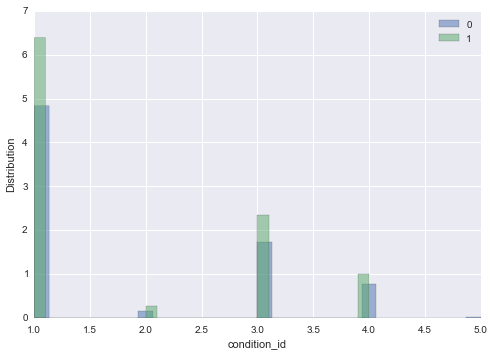

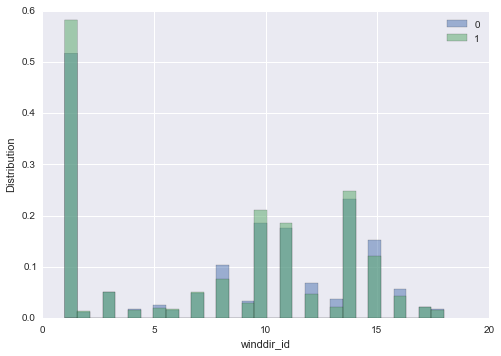

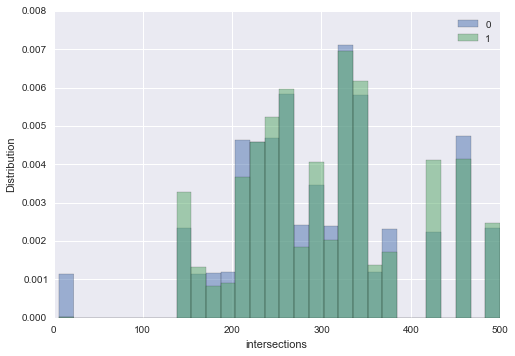

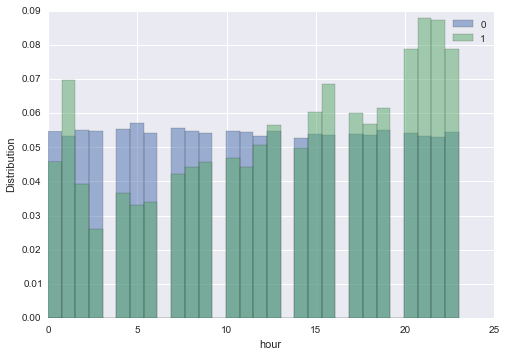

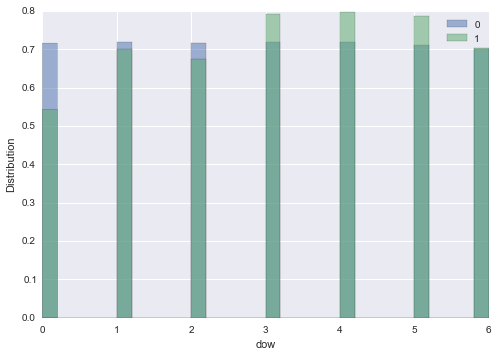

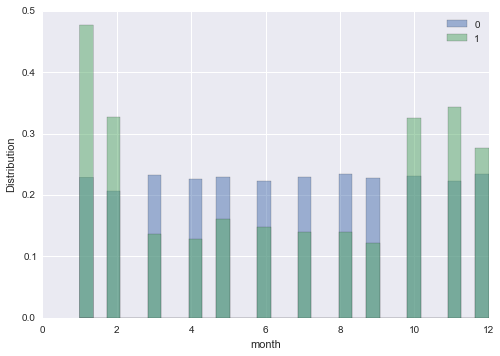

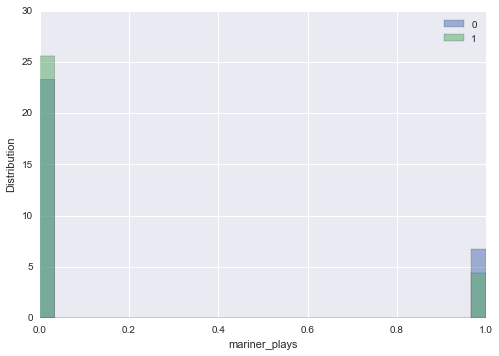

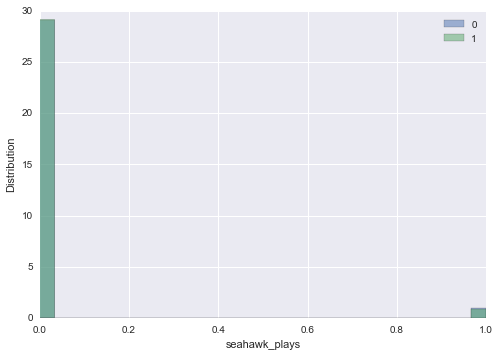

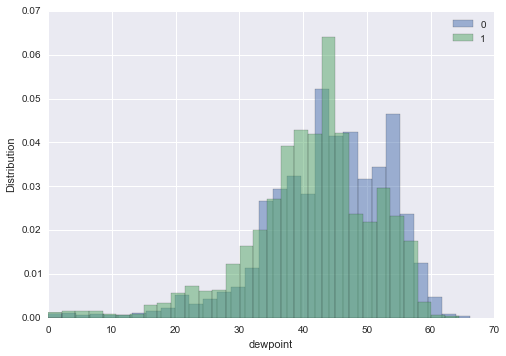

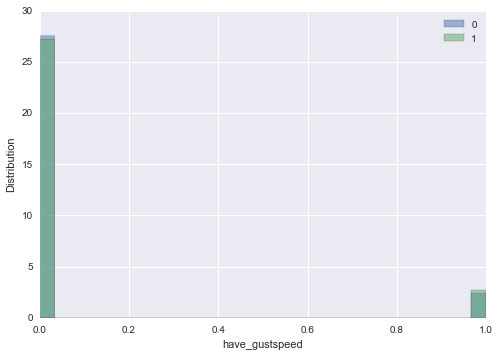

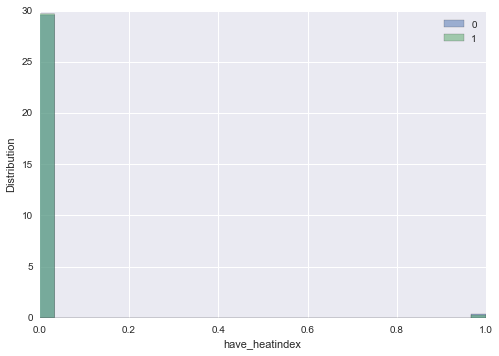

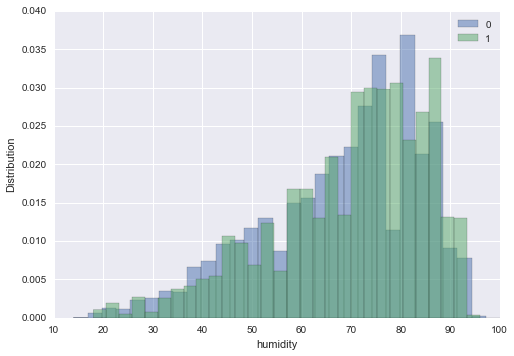

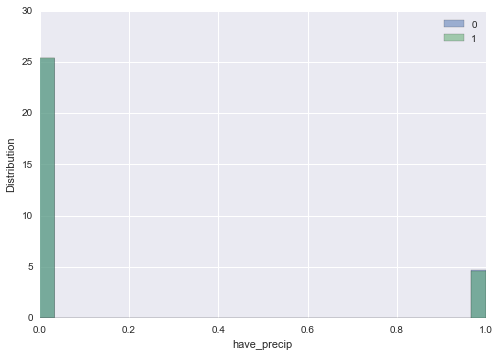

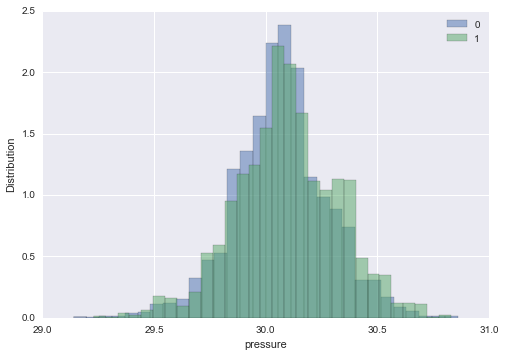

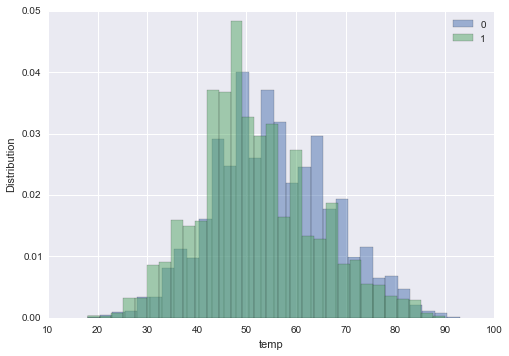

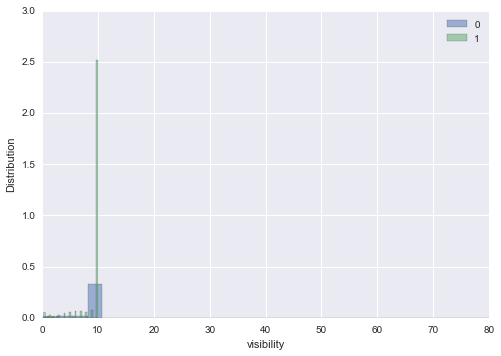

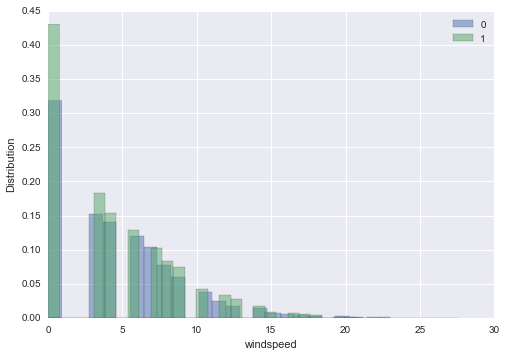

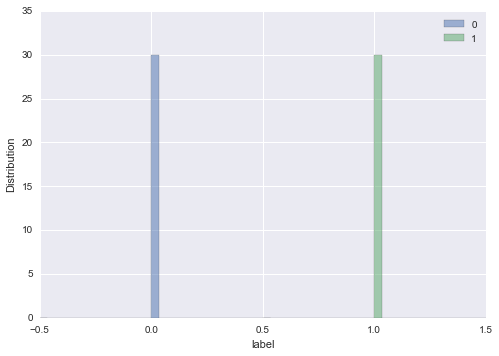

In [60]:
for col in train_sample.columns:
    plt.hist(train_sample_neg[col].values, bins=30, alpha=0.5, label='0', normed=True)
    plt.hist(train_sample_pos[col].values, bins=30, alpha=0.5, label='1', normed=True)
    plt.legend()
    plt.xlabel(col)
    plt.ylabel('Distribution')
    plt.show()

In [61]:
print '0 label count:', train_df[train_df.label == 0]['label'].count()
print '1 label count:', train_df[train_df.label == 1]['label'].count()

0 label count: 884189
1 label count: 23055


In [62]:
y_train = train_df.pop('label').values

In [63]:
X_train = train_df.sort(axis=1).values

In [64]:
train_df.sort(axis=1).head().T

,0,1,2,3,4
condition_id,1.00,3.00,4.00,4.00,1.00
dewpoint,28.90,19.90,30.00,35.10,42.10
dow,2.00,4.00,4.00,5.00,5.00
have_gustspeed,0.00,0.00,0.00,0.00,0.00
have_heatindex,0.00,0.00,0.00,0.00,0.00
have_precip,0.00,0.00,1.00,1.00,0.00
hour,1.00,6.00,19.00,1.00,14.00
humidity,88.00,75.00,73.00,86.00,71.00
intersections,302.00,344.00,264.00,243.00,297.00
mariner_plays,0.00,0.00,0.00,0.00,0.00


#### Doesn't look great... lets just try some models

In [65]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat = encoder.fit_transform(X_train)
scaler = StandardScaler()
mat2 = scaler.fit_transform(mat.toarray())

In [66]:
logit = LogisticRegression(class_weight='auto')

In [67]:
cvs = cross_val_score(logit, mat2, y_train, scoring='roc_auc', cv=5)

In [68]:
cvs

array([ 0.70394543,  0.70070227,  0.69695437,  0.70514801,  0.68426998])

In [69]:
np.mean(cvs)

0.69820401111859387

In [70]:
y_test = test_df.pop('label').values
X_test = test_df.sort(axis=1).values

In [71]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat_train = encoder.fit_transform(X)
scaler = StandardScaler()
mat_train2 = scaler.fit_transform(mat_train.toarray())
logit = LogisticRegression(class_weight='auto').fit(mat_train2, y_train)
mat_test = encoder.transform(X_test)
mat_test2 = scaler.transform(mat_test.toarray())

In [72]:
predict = logit.predict(mat_test2)
roc_auc_score(predict, y_test)

0.50541001388851325

In [90]:
[row[1] for row in logit.predict_proba(mat_test2)]

[0.60560259109548598,
 0.64789699920824984,
 0.6185663227812116,
 0.59339026827457364,
 0.73821879018493042,
 0.60034474307822494,
 0.74421714853582854,
 0.7198663266406512,
 0.63418223101293614,
 0.65421285456961453,
 0.82012207645752055,
 0.74410669156565712,
 0.7940839281342057,
 0.6730410334384801,
 0.62883586640055744,
 0.66047485483189761,
 0.69576550686238048,
 0.63439004697028734,
 0.67301051109287224,
 0.66533321611278673,
 0.65369773916376295,
 0.79042013059640626,
 0.71192956512278938,
 0.79335829790283607,
 0.64147499805904995,
 0.66355500205105256,
 0.50379125905716815,
 0.80889329272773514,
 0.78927243739060715,
 0.76572776650045082,
 0.6935101803586895,
 0.69344332203755965,
 0.7287570138321986,
 0.74867287934217641,
 0.90154103240786243,
 0.76109429429083186,
 0.51036494059394777,
 0.74627584210109388,
 0.75288566471754015,
 0.81827929780391939,
 0.78217344047033843,
 0.74821588982297793,
 0.017022235025324354,
 0.78875942208237604,
 0.8300965339702463,
 0.7650105613533

In [81]:
rnf = RandomForestClassifier(class_weight='auto', n_estimators=100)

In [83]:
cvs = cross_val_score(rnf, X_train, y_train, scoring='roc_auc', cv=5)
print cvs
print np.mean(cvs)

[ 0.67488277  0.6709667   0.66989184  0.67579284  0.66454669]
0.671216169565


In [84]:
rnf.fit(X_train, y_train)
roc_auc_score(rnf.predict(X_test), y_test)

0.47857875301551173

In [24]:
gbc = GradientBoostingClassifier()

In [25]:
cvs = cross_val_score(gbc, X, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

[ 0.64778094  0.65726396  0.65503642  0.63796406  0.66797456  0.62909502
  0.65952696  0.67136892  0.66499142  0.65643397]
0.654743622417


In [26]:
gbc.fit(X_train, y_train)
roc_auc_score(gbc.predict(X_test), y_test)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [91]:
max([x[1] for x in gbc.predict_proba(X_test)])

0.6377142759148442

In [55]:
svc = SVC(class_weight='auto')

In [ ]:
cvs = cross_val_score(svc, mat, y, scoring='roc_auc', cv=10)
print cvs
print np.mean(cvs)

#### Lets try expanding on RNF

In [68]:
pd.Series([x[1] for x in rnf.predict_proba(X_test)]).unique()

array([ 0.02,  0.08,  0.03,  0.01,  0.04,  0.05,  0.  ,  0.21,  0.06,
        0.09,  0.11,  0.1 ,  0.16,  0.56,  0.24,  0.07,  0.2 ,  0.12,
        0.39,  0.14,  0.13,  0.15,  0.31,  0.34,  0.25,  0.17,  0.18,
        0.36,  0.35,  0.29,  0.43,  0.23,  0.19,  0.32,  0.49,  0.44,  0.52])

In [79]:
auc = []
for n in xrange(10, 101):
    rnf = RandomForestClassifier(class_weight='auto', n_estimators=n)
    cvs = cross_val_score(rnf, X, y, scoring='roc_auc', cv=5)
    auc.append(np.mean(cvs))

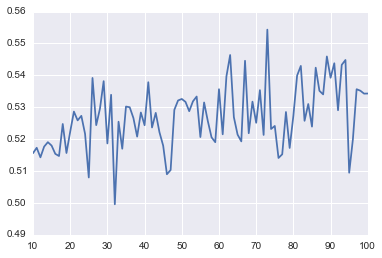

In [80]:
plt.plot(range(10, 101), auc)

In [ ]:
# Grid param modified to only store the ones preferred
random_forest_grid = {
                      'max_depth': [3, 6, 9],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [5, 10, 15],
                      'min_samples_leaf': [5, 10, 15],
                      'bootstrap': [False, True],
                      'n_estimators': [100],
                      'random_state': [None, 20, 200],
                      'class_weight': ['auto']
                     }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(X, y)

print "best parameters:", rf_gridsearch.best_params_

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


In [207]:
rnf = RandomForestClassifier(class_weight = 'auto')
rnf.fit(X_train, y_train)
rnf_df = pd.DataFrame(X_test, columns=df2.columns)
rnf_df['proba'] = pd.Series([x[1] for x in rnf.predict_proba(X_test)])
rnf_df['label'] = pd.Series(y_test)

In [208]:
rnf_df['proba_bins'] = pd.cut(rnf_df['proba'], bins=3)

In [209]:
roc_auc_score(rnf.predict(X_test), y_test)

0.72995991983967934

In [168]:
rnf_df.head().T

,0,1,2,3,4
zone_beat_id,18,17,18,18,19
condition_id,39.2,37,46.9,51.8,33.1
winddir_id,3,3,5,4,5
hour,0,0,0,21.9,0
dow,0,0,0,0,0
month,7,19,22,14,18
mariner_plays,87,71,69,68,70
seahawk_plays,0,0,0,0,0
dewpoint,12,11,11,7,11
gustspeed,0,0,0,0,0


In [169]:
rnf_df[['proba_bins', 'label']].groupby('proba_bins', as_index=False).agg({'label': ['sum','mean', 'count']})

proba_bins label                
                     sum      mean count
0  (0.025, 0.0749]    75  0.039288  1909
1  (0.0749, 0.125]     6  0.072289    83
2   (0.125, 0.175]     1  0.125000     8

####Trying multi downsampling methods

In [92]:
X_test

array([[  3. ,  24.1,   4. , ...,   1. ,   0. ,   1. ],
       [  3. ,  24.1,   4. , ...,   1. ,   0. ,   2. ],
       [  3. ,  24.1,   4. , ...,   1. ,   0. ,   3. ],
       ..., 
       [  3. ,  46.9,   1. , ...,   9. ,   3.5,  50. ],
       [  3. ,  46.9,   1. , ...,   9. ,   3.5,  51. ],
       [  3. ,  46.9,   1. , ...,   9. ,   3.5,  52. ]])

In [93]:
encoder = OneHotEncoder(categorical_features=[0, 2, 6, 10, 15, 17])
mat_train = encoder.fit_transform(X_train)

In [94]:
scaler = StandardScaler()
mat_train2 = scaler.fit_transform(mat_train.toarray())

In [95]:
logit = LogisticRegression(class_weight='auto')

In [96]:
cvs = cross_val_score(logit, mat_train2, y, scoring='roc_auc', cv=5)

In [97]:
cvs

array([ 0.70394543,  0.70070227,  0.69695437,  0.70514801,  0.68426998])

In [98]:
mat_test = encoder.transform(X_test)
mat_test2 = scaler.transform(mat_test.toarray())

In [99]:
logit.fit(mat_train2, y_train)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [100]:
predict = logit.predict(mat_test2)
roc_auc_score(predict, y_test)

0.50541001388851325

In [217]:
kcluster = KMeans()
#clusters = kcluster.fit_predict(np.concatenate((mat_train2, y_train.reshape((y_train.shape[0], 1))), axis=1))
clusters = kcluster.fit_predict(mat_train2)

In [238]:
clusters

array([3, 3, 6, ..., 3, 4, 3], dtype=int32)

In [218]:
sizes = []
for i in xrange(max(clusters)):
    test = y_train[clusters == i]
    sizes.append(len(test))

In [219]:
def balance_xy(X, y):
    pos_X = X[y == 1]
    pos_y = y[y == 1]
    neg_X = X[y == 0]
    neg_y = y[y == 0]
    rand = np.random.choice(range(len(neg_y)), len(pos_y))
    neg_X = neg_X[rand]
    neg_y = neg_y[rand]
    return np.concatenate((pos_X, neg_X), axis=0), np.concatenate((pos_y, neg_y), axis=0)

In [220]:
def upsample(X, y):
    pos_X = X[y == 1]
    pos_y = y[y == 1]
    neg_X = X[y == 0]
    neg_y = y[y == 0]
    rand = np.random.choice(range(len(pos_X)), len(neg_y))
    pos_X = pos_X[rand]
    pos_y = pos_y[rand]
    return np.concatenate((pos_X, neg_X), axis=0), np.concatenate((pos_y, neg_y), axis=0)

In [221]:
models = []
for i in xrange(max(clusters)):
    temp_mat = mat2[clusters == i]
    temp_y = y_train[clusters == i]
    #temp_mat, temp_y = upsample(temp_mat, temp_y)
    logit = LogisticRegression(class_weight='auto').fit(temp_mat, temp_y)
    models.append(logit)
    #rnf = RandomForestClassifier(class_weight = 'auto').fit(temp_mat, temp_y)
    #models.append(rnf)

In [222]:
predictions = []
predict_proba = []
for i in xrange(max(clusters)):
    pred = models[i].predict(mat_test2)
    proba = models[i].predict_proba(mat_test2)
    predictions.append(pred)
    predict_proba.append(proba)

In [241]:
arr = [1 if i else 0 for i in np.array(predictions).sum(axis=0) > 4]

In [225]:
roc_auc_score(arr, y_test)

0.50983055523822085

In [226]:
sum_size = sum(sizes)

In [227]:
weights = 1. * np.array(sizes) / sum_size

In [228]:
inverse_sizes = 1. / np.array(sizes)

In [229]:
inverse_sizes

array([  5.28317836e-05,   1.40268193e-05,   4.54305911e-06,
         3.23586896e-06,   1.56474933e-05,   1.48156928e-05,
         1.03058785e-05])

In [230]:
inverse_sum = sum(inverse_sizes)

In [231]:
inverse_weights = 1. * np.array(inverse_sizes) / inverse_sum

In [232]:
inverse_weights

array([ 0.45778825,  0.12154261,  0.03936568,  0.02803886,  0.13558578,
        0.12837822,  0.0893006 ])

In [233]:
new_proba = None
for i, w in enumerate(inverse_weights):
    if new_proba is None:
        new_proba = w * predict_proba[i][:, 1]
    else:
        new_proba = new_proba + w * predict_proba[i][:, 1]

In [234]:
predict_proba[0][:, 1]

array([ 0.83271856,  0.87282385,  0.80785755, ...,  0.12534156,
        0.16351539,  0.10445531])

In [235]:
predict_proba[1][:, 1]

array([ 0.65453119,  0.77311577,  0.73846505, ...,  0.61426507,
        0.55600945,  0.57399377])

In [236]:
for p in predictions:
    print roc_auc_score(p, y_test)

0.503195199014
0.506801962296
0.508552951888
0.506939719304
0.510928565193
0.50637699176
0.502639536957


In [237]:
for i in xrange(200):
    print new_proba[i], predict_proba[2][i][1], y_test[i]

0.555592364055 0.142658796938 0
0.621138482995 0.207741171201 0
0.576337357568 0.150915241972 0
0.536468403547 0.122699793239 0
0.686161387594 0.28199837787 0
0.560610028397 0.160062326002 0
0.688263109949 0.296853375792 0
0.6544309169 0.203277862199 0
0.632556192291 0.176579082654 0
0.631860551264 0.172831478309 0
0.745635994631 0.371918439336 0
0.689949605175 0.307943141901 0
0.725334852388 0.383078788291 0
0.618884828555 0.253509965629 0
0.58749444862 0.208346671922 0
0.63902673182 0.223584900015 0
0.635907743189 0.24093941479 0
0.520815611757 0.178108714267 0
0.661672837108 0.184794648312 0
0.643744629188 0.137715750008 0
0.642288312548 0.158466708426 0
0.721172393944 0.312399824874 0
0.668798399886 0.214174766514 0
0.728540367958 0.338295968027 0
0.636456230522 0.196401658775 0
0.628344984542 0.196694360583 0
0.558316010682 0.111690263973 0
0.735823277004 0.333687295967 0
0.707573968483 0.304683300082 0
0.711900637502 0.29693207409 0
0.649043291477 0.220383968727 0
0.58615403581 0

In [108]:
mat22, y_train2 = upsample(mat2, y_train)
logit = LogisticRegression(class_weight='auto')
logit.fit(mat22, y_train2)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [109]:
predict = logit.predict(mat2_test)
roc_auc_score(predict, y_test)

0.51290934996163251

In [57]:
pca = PCA(n_components=10)
mat22 = pca.fit_transform(mat2)

In [58]:
print(pca.explained_variance_ratio_)

[ 0.03302433  0.02841108  0.02821599  0.0281087   0.02796441  0.02782656
  0.0277976   0.02762072  0.02748459  0.02739351]


In [59]:
logit = LogisticRegression(class_weight='auto')
logit.fit(mat22, y_train)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [60]:
predict = logit.predict(pca.transform(mat2_test))
roc_auc_score(predict, y_test)

0.50299172029630346